In [1]:
# importing all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# for transforming full dataset to lie between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# for creating the model
import tensorflow as tf
keras = tf.keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,LSTM

# for saving the model
from keras.models import load_model

# for exporting important objects of model
import joblib


In [2]:
# read daily stock price data of Vedanta as a CSV file 
data = pd.read_csv("VEDL.NS(1).csv", index_col='Date')

In [3]:
# show first 5 rows of the data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,10.76250,11.00000,10.7625,10.92500,3.475072,44000.0
1996-01-02,10.92500,11.02625,10.8250,10.90125,3.467519,34000.0
1996-01-03,10.90125,11.00000,10.9000,11.00000,3.498930,16000.0
1996-01-04,10.75000,10.87500,10.7500,10.75000,3.419409,24000.0
1996-01-05,10.50000,10.75000,10.5000,10.68750,3.399527,10000.0


<AxesSubplot:xlabel='Date'>

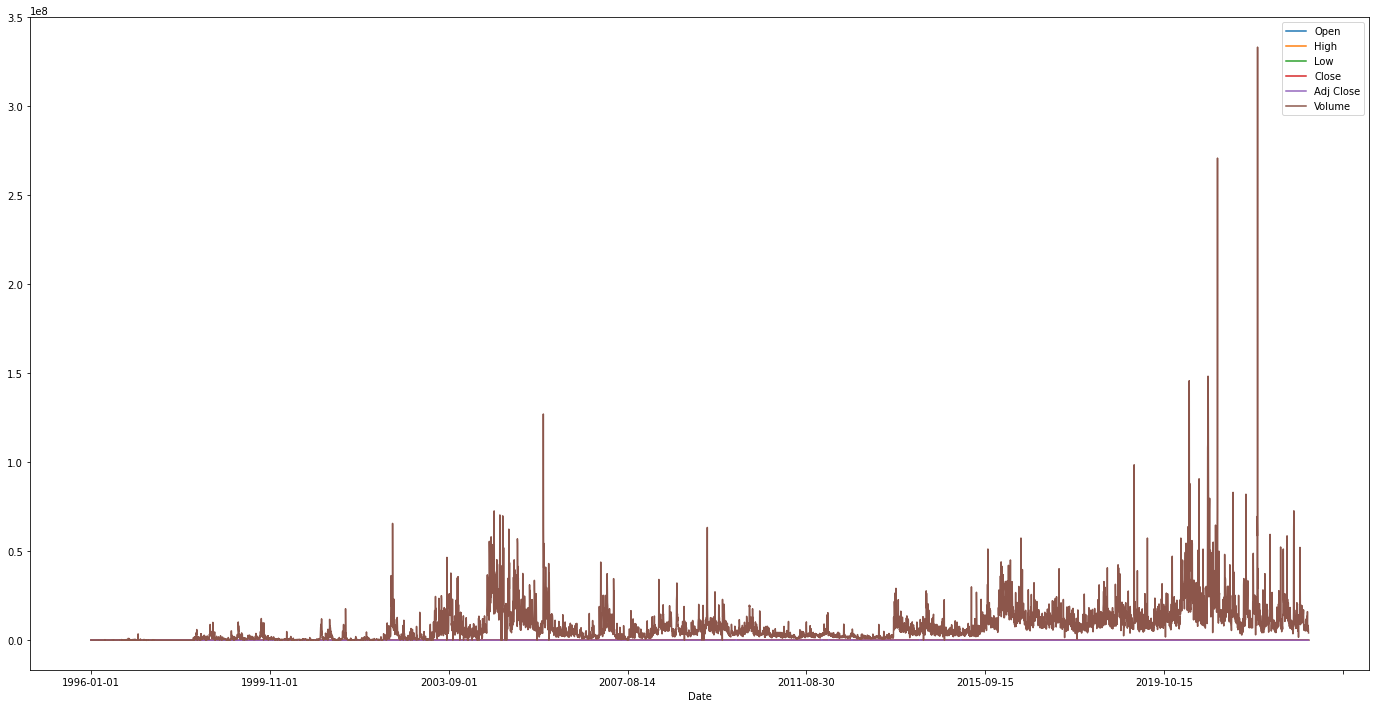

In [4]:
# just a random plot
data.plot(figsize=(24,12))

In [5]:
# check for all NaN values in data
data.isnull().all(axis=1).sum()

17

In [6]:
# removing all NaN values
data = data.dropna()

In [7]:
data.isnull().all(axis=1).sum()

0

In [8]:
len(data)

6792

In [9]:
# tranform complete dataset 
scaled_data = scaler.fit_transform(data)

In [10]:
# dataset has 6792 rows and 6 columns
# meaning we have 6 properties in our stock price - [Date, High, Low, Close, Adj Close, Volume]
# and we have stock price for 6792 days i.e. almost 26 years worth data
scaled_data.shape

(6792, 6)

In [11]:
# model will go back to 31 days worth of data for learning and predicting (2 separate tasks )
look_back = 31

# creating generator form of dataset. it generates a tuple of (X,y) where X is the array of look_back days worth of data
# and y is the array of next day's stock price i.e. the 32nd day's stock price in this case
full_data_generator = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=1)

In [ ]:
# check the definition of full_data_generator below by uncommenting the following line
# X,y = full_data_generator[0]

In [15]:
# defining the model
model = Sequential()

# the number of features in our dataset we want to predict 
# in our dataset we have 6 features - [Date, High, Low, Close, Adj Close, Volume]
# similarly we can have more features hence the dynamic allocation of the below variable
# if we have single feature that we want to predict then n_features = 1
n_features = scaled_data.shape[1]


model.add(LSTM(8, activation='relu', return_sequences=True , input_shape=(look_back,n_features)))
model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(look_back,n_features)))
model.add(LSTM(32, activation='relu',  input_shape=(look_back,n_features)))

# output layer
# we have 6 features in our dataset hence add that much neurons in this dense output layer
model.add(Dense(n_features))

# compiling the model
model.compile(optimizer='adam', loss='mse')

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 31, 8)             480       
_________________________________________________________________
lstm_4 (LSTM)                (None, 31, 16)            1600      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 8,550
Trainable params: 8,550
Non-trainable params: 0
_________________________________________________________________


In [17]:
# start training the model
# time series data takes longer to train , hence choose epochs accordingly
model.fit_generator(full_data_generator, epochs=5)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-30 07:44:07.371123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
6761/6761 [==============================] - 1136s 167ms/step - loss: 0.0020
Epoch 2/5
6761/6761 [==============================] - 1123s 166ms/step - loss: 5.9030e-04
Epoch 3/5
6761/6761 [==============================] - 1129s 167ms/step - loss: 3.9933e-04
Epoch 4/5
6761/6761 [==============================] - 1121s 166ms/step - loss: 3.1841e-04
Epoch 5/5
6761/6761 [==============================] - 1118s 165ms/step - loss: 2.9420e-04


<AxesSubplot:>

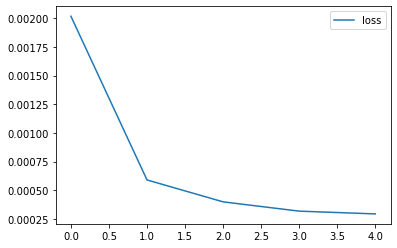

In [18]:
# checking out the losses during training
loss = pd.DataFrame(model.history.history)
loss.plot()

In [18]:
# predicting only 1 datapoint into unknown future. Each value corresponds to the columns in the dataset
# model predicts this single value by checking the previous 31 days .
first_eval_batch = scaled_data[-look_back:]
first_eval_batch = first_eval_batch.reshape((1, look_back, scaled_data.shape[1]))
model.predict(first_eval_batch)

1/1 [==============================] - 0s 40ms/step


array([[0.58078384, 0.5905622 , 0.59218395, 0.58782387, 0.8056017 ,
        0.04248916]], dtype=float32)

In [28]:
# print the very last value in the dataset
scaled_data[-1]

array([0.64578842, 0.64578842, 0.66109734, 0.64458196, 0.89889322,
       0.01215344])

In [29]:
# saving the model for future use
model.save('/kaggle/working/initial_model.h5')

In [13]:
# create PKL files of important objects required for project
# these are required for prediction of future stock prices and also for the flask app
joblib.dump(scaler, "Imp Objects/ini_scaler.pkl")
joblib.dump(scaled_data, "Imp Objects/scaled_data.pkl")
joblib.dump(look_back, "Imp Objects/look_back.pkl")


['Imp Objects/look_back.pkl']

In [12]:
# Load the model and the PKL files for prediction
init_model = load_model('initial_model.h5')
init_scaler = joblib.load('Imp Objects/ini_scaler.pkl')
init_look_back = joblib.load("Imp Objects/look_back.pkl")
init_scaled_data = joblib.load("Imp Objects/scaled_data.pkl")

BELOW CAN BE USED TO TEST THE MODEL ON LOCAL COMPUTER OR ON KAGGLE

In [13]:
# User inputs how many days into the future they want to predict
# n_days_to_predict = int(input("Enter the number of days you want to predict into the future: "))

In [14]:
# create the predictions
# n_features = scaled_data.shape[1]

# this array will contain the predictions
# forecast = []

# create batches of 31 days worth of data  starting from the last 31 days of the dataset
# first_eval_batch = scaled_data[-look_back:]

# reshape the batch to be fed into the model according to the model's input shape
# current_batch = first_eval_batch.reshape((1, look_back, n_features))

# loop for predicting the next day's stock price for n_days_to_predict entered above
# for i in range(n_days_to_predict):
     # predict the next day's stock price 32nd day's stock price in this case
#     current_pred = init_model.predict(current_batch)[0]
    # add the prediction to the forecast array
#     forecast.append(current_pred)
    # remove the very last day's data from the end of the batch and append the prediction to the batch
#     current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 1s 1s/step


In [15]:
# inverse transform into original size
# true_forecast = scaler.inverse_transform(forecast)
# true_forecast

array([[2.87884162e+02, 2.92715220e+02, 2.81902495e+02, 2.88805284e+02,
        2.83774735e+02, 1.41633892e+07]])

In [38]:
# this function takes the model, scaler and number of days to predict as input
# and returns the predictions
# this function is used in the flask app
# and is exactly the same as the code above
def return_predictions(model, scaler, num_days):
    n_features = init_scaled_data.shape[1]

    forecast = []

    first_eval_batch = init_scaled_data[-init_look_back:]

    current_batch = first_eval_batch.reshape((1, init_look_back, n_features))

    for i in range(num_days):
        current_pred = init_model.predict(current_batch)[0]

        forecast.append(current_pred)

        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
    true_forecast = init_scaler.inverse_transform(forecast)
    # return true_forecast
    return true_forecast

In [42]:
# calling the function to get the predictions and storing it in a variable
pred = (return_predictions(init_model, init_scaler, 1))[0][1].round(3)
pred

1/1 [==============================] - 0s 88ms/step


292.715